In [1]:
from itertools import groupby
import tensorflow as tf
import random
import torch
import numpy as np
####### READING THE FASTA CHAIN DATA FROM THE FILE ############

def fasta_iter(name):
    fh = open(name)

    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))

    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()[1:].strip()

        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.__next__())

        yield (headerStr, seq)

data=fasta_iter("Ecoli_prom.fa.txt")
training_data=[]

######## CONVERTING DNA SEQUENCE INTO ONE HOT ENCODING ##########

for chain in data:
    headerStr, seq = chain
    #print(seq)
    temp=[]
    for i in seq:
        if(i=='A'):
            temp.append([1,0,0,0])
        if(i=='T'):
            temp.append([0,1,0,0])
        if(i=='G'):
            temp.append([0,0,1,0])
        if(i=='C'):
            temp.append([0,0,0,1])
    
    training_data.append(temp)
       
    
    
data=fasta_iter("Ecoli_non_prom.fa.txt")
for chain in data:
    headerStr, seq = chain
    temp=[]
    for i in seq:
        if(i=='A'):
            temp.append([1,0,0,0])
        if(i=='T'):
            temp.append([0,1,0,0])
        if(i=='G'):
            temp.append([0,0,1,0])
        if(i=='C'):
            temp.append([0,0,0,1])
        
    training_data.append(temp)



In [2]:
########### CREATING LABELS FOR THE OUTPUT ###########
labels=[]
for i in range(839):
    labels.append(1)
for i in range(3000):
    labels.append(0)

#### SHUFFLE THE DATA ########    

comb=list(zip(training_data,labels))
random.shuffle(comb)
training_data,labels=zip(*comb)


print(np.shape(training_data))
print(np.shape(labels))

training_data=np.reshape(training_data,(3839,81,1,4))

print(np.shape(training_data))


(3839, 81, 4)
(3839,)
(3839, 81, 1, 4)


In [3]:
####### SPLITTING DATA INTO TRAIN,VALIDATION AND TEST ############
X_train=training_data[:3000]
Y_train=labels[:3000]

X_valid=training_data[3000:3400]
Y_valid=labels[3000:3400]

X_test=training_data[3400:]
Y_test=labels[3400:]

In [4]:
#one-hot encode target column
from keras.utils import to_categorical

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
y_valid =to_categorical(Y_valid)


/home/vinayak/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
###### CREATING MODEL ############
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation

model = Sequential()
#add model layers
model.add(Conv2D(200, kernel_size=(21,1), input_shape=(81,1,4),strides=2))
model.add(MaxPooling2D(pool_size=(31,1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation='sigmoid'))

In [6]:
#### USING ADAM'S OPTIMIZER AND COMPUTING CROSS-ENTROPY LOSS ########
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
####### TRAINING FOR 25 EPOCHS ##########
history=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15)

Train on 3000 samples, validate on 400 samples
Epoch 1/15
3000/3000 [==============================] - 1s 271us/step - loss: 0.4030 - acc: 0.8163 - val_loss: 0.3515 - val_acc: 0.8500
Epoch 2/15
3000/3000 [==============================] - 1s 237us/step - loss: 0.2613 - acc: 0.8903 - val_loss: 0.2971 - val_acc: 0.8700
Epoch 3/15
3000/3000 [==============================] - 1s 224us/step - loss: 0.2000 - acc: 0.9197 - val_loss: 0.2860 - val_acc: 0.8750
Epoch 4/15
3000/3000 [==============================] - 1s 241us/step - loss: 0.1543 - acc: 0.9423 - val_loss: 0.3079 - val_acc: 0.8675
Epoch 5/15
3000/3000 [==============================] - 1s 231us/step - loss: 0.1017 - acc: 0.9677 - val_loss: 0.2864 - val_acc: 0.8850
Epoch 6/15
3000/3000 [==============================] - 1s 225us/step - loss: 0.0601 - acc: 0.9850 - val_loss: 0.2891 - val_acc: 0.8975
Epoch 7/15
3000/3000 [==============================] - 1s 223us/step - loss: 0.0347 - acc: 0.9930 - val_loss: 0.3244 - val_acc: 0.8725
E

In [8]:
#PREDICTING THE OUTPUT
output=model.predict(X_test)
for i in range(len(output)):
    if (output[i][0]>output[i][1]):
        output[i][0]=1
        output[i][1]=0
    else:
        output[i][0]=0
        output[i][1]=1

In [9]:
# CALCULATING ACCURACY
true_count=0
for i in range(len(output)):
    if output[i][0]==y_test[i][0]:
        true_count+=1
acc=true_count/len(output)*100

In [10]:
print("Accuracy: ",acc)

Accuracy:  93.62186788154897


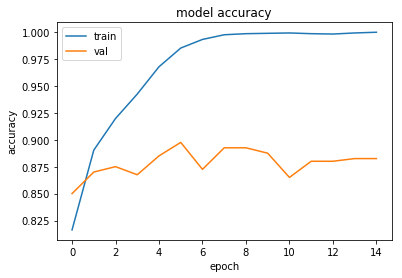

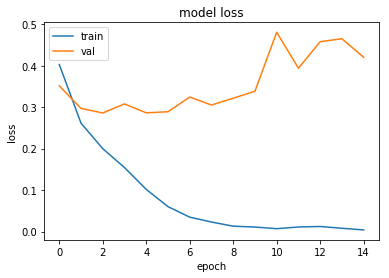

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()